In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from utils import show_graph

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:
def train():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    iterep = 500
    for i in range(iterep * 30):
        x_train, y_train = mnist.train.next_batch(100)
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': mnist.train.images,
                                     'y:0': mnist.train.labels,
                                     'phase:0': 1})
            t = sess.run([loss, accuracy], 
                         feed_dict={'x:0': mnist.test.images,
                                    'y:0': mnist.test.labels,
                                    'phase:0': 0})
            history += [[epoch] + tr + t]
            print history[-1]
    return history

# No batch normalization

In [25]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [26]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu(x, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, y))

In [27]:
show_graph(tf.get_default_graph().as_graph_def())

In [28]:
history = train()

[1, 0.6100108, 0.84658182, 0.58416647, 0.85619998]
[2, 0.41835651, 0.88398182, 0.39695036, 0.89249998]
[3, 0.35918671, 0.89810908, 0.34221739, 0.90280002]
[4, 0.3232955, 0.90798181, 0.30865157, 0.912]
[5, 0.29959169, 0.91474545, 0.28651989, 0.91820002]
[6, 0.28090578, 0.92034543, 0.27004412, 0.92290002]
[7, 0.26679453, 0.92354548, 0.25686544, 0.92510003]
[8, 0.25269052, 0.92801815, 0.24400532, 0.93010002]
[9, 0.24178712, 0.93080002, 0.23501205, 0.93229997]
[10, 0.23321132, 0.93358183, 0.22524764, 0.93620002]
[11, 0.22217204, 0.93661821, 0.21682265, 0.93550003]
[12, 0.2145717, 0.93889093, 0.21104936, 0.93970001]
[13, 0.20633599, 0.94061816, 0.20256288, 0.9404]
[14, 0.1996906, 0.94334543, 0.19783841, 0.94450003]
[15, 0.19281986, 0.94452727, 0.19271576, 0.94389999]
[16, 0.18904918, 0.9467091, 0.18823543, 0.94520003]
[17, 0.1808165, 0.94819999, 0.18020816, 0.94700003]
[18, 0.17546111, 0.95039999, 0.17586617, 0.94770002]
[19, 0.16955148, 0.95172727, 0.17250031, 0.94950002]
[20, 0.16499829, 

# Standard batch normalization

In [16]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [17]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_batch_relu(x, phase,'layer1')
h2 = dense_batch_relu(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, y))

In [18]:
show_graph(tf.get_default_graph().as_graph_def())

In [19]:
history_bn = train()

[1, 0.4256874, 0.89429092, 1.2155629, 0.85799998]
[2, 0.29499948, 0.9222182, 0.71303284, 0.91839999]
[3, 0.23862627, 0.93616366, 0.4435626, 0.9321]
[4, 0.2042135, 0.94470906, 0.30149227, 0.93889999]
[5, 0.18044354, 0.95023638, 0.23172256, 0.94569999]
[6, 0.16233754, 0.9552182, 0.19313155, 0.95050001]
[7, 0.14779446, 0.95952725, 0.17301475, 0.95300001]
[8, 0.13569504, 0.96245456, 0.15639855, 0.95639998]
[9, 0.12529458, 0.96541816, 0.14725566, 0.95850003]
[10, 0.11639864, 0.96805453, 0.13915965, 0.95990002]
[11, 0.10895661, 0.9702, 0.13038664, 0.96200001]
[12, 0.10213169, 0.97252727, 0.12431522, 0.96310002]
[13, 0.095611326, 0.97507274, 0.12248854, 0.96350002]
[14, 0.089817829, 0.97621816, 0.11631969, 0.96600002]
[15, 0.084802456, 0.97783637, 0.11202146, 0.96780002]
[16, 0.079967417, 0.97909093, 0.10961597, 0.96789998]
[17, 0.07606519, 0.98052728, 0.10784775, 0.96850002]
[18, 0.072009385, 0.98154545, 0.10404842, 0.9698]
[19, 0.068293147, 0.98287272, 0.10126401, 0.97060001]
[20, 0.0651799

# Post-activation batch normalization

In [20]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [21]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu_batch(x, phase,'layer1')
h2 = dense_relu_batch(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, y))

In [22]:
show_graph(tf.get_default_graph().as_graph_def())

In [23]:
history_post_bn = train()

[1, 0.29388592, 0.91945457, 1.3046201, 0.83859998]
[2, 0.21552213, 0.94, 0.88956189, 0.89160001]
[3, 0.17754138, 0.95025456, 0.58493733, 0.92720002]
[4, 0.15322003, 0.95767272, 0.3652952, 0.94239998]
[5, 0.13537221, 0.96219999, 0.25398657, 0.94980001]
[6, 0.12123783, 0.96685457, 0.19601743, 0.95420003]
[7, 0.11067251, 0.96939999, 0.15950939, 0.95740002]
[8, 0.10161781, 0.97274548, 0.13935977, 0.96109998]
[9, 0.093822926, 0.97441816, 0.12707961, 0.96270001]
[10, 0.086537801, 0.97712725, 0.11842595, 0.96439999]
[11, 0.080877155, 0.97869092, 0.11453144, 0.96600002]
[12, 0.074531145, 0.9806909, 0.10914696, 0.96649998]
[13, 0.07019005, 0.98194546, 0.10925256, 0.9655]
[14, 0.065838121, 0.98303634, 0.10426167, 0.9673]
[15, 0.061687943, 0.98449093, 0.10245565, 0.96929997]
[16, 0.0579843, 0.98525453, 0.10216489, 0.96780002]
[17, 0.054425441, 0.98647273, 0.099322498, 0.96869999]
[18, 0.051386438, 0.98732728, 0.097551085, 0.9698]
[19, 0.048832081, 0.98809093, 0.095235735, 0.96990001]
[20, 0.04628

# Evaluation

In [29]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [30]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

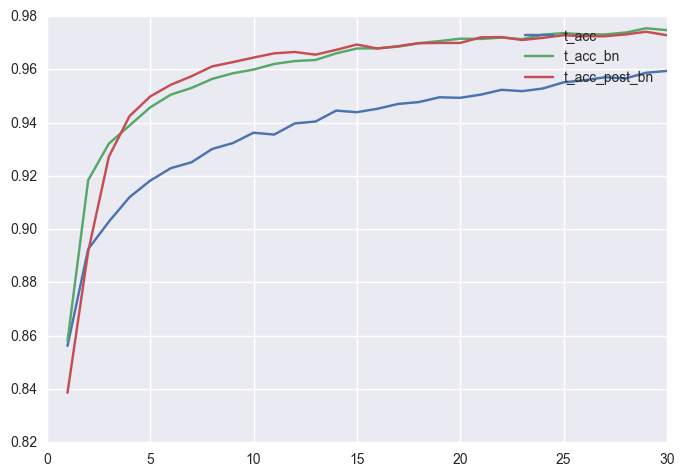

In [32]:
plt.plot(history[:, 0], history[:, -1], label='t_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='t_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='t_acc_post_bn')
plt.legend()